# Running your ideal zip codes to buy based on your preferences

In [1]:
# Dependencies

import gmaps
import numpy as np
import pandas as pd
import requests
import time
import scipy.stats as st
from datetime import datetime
from scipy.stats import linregress
from matplotlib import pyplot as plt
from config_Laura import (gkey)

In [2]:
#importing datasets
walkscore_map = pd.read_csv('Resources_Laura/walkscore_mapping.csv')
property_dataset = pd.read_csv('Resources_Laura/clean_property_value.csv')
roi = pd.read_csv('Resources_Moe/Moe_ROI_CA.csv')
crime_rates = pd.read_csv('Resources_Fernando/Resources/ca_crime_2019_clean.csv')

In [3]:
#find mean of crime rates per county
crime_rates = crime_rates.rename(columns={'Total':'Total Crimes'})
crime_rates = crime_rates[['County','Total Crimes']]
crime_rates = crime_rates.groupby('County').mean()
crime_rates.head()

,Total Crimes
County,
Alameda County,2378.476190
Alpine County,7.500000
Amador County,75.833333
Butte County,334.300000
Calaveras County,94.400000


In [4]:
#selecting specific columns for the ROI csv file, renaming and indexing zip code
roi = roi[['Zip_Code','Median_ROI']]
roi_clean = roi.rename(columns={'Zip_Code':'ZipCode'})
roi_clean = roi_clean.set_index('ZipCode')

In [5]:
## rename region name to zip code
property_dataset = property_dataset.rename(columns={'RegionName':'ZipCode','CountyName':'County'})

## only use walkscore with zip code and scores (remove lat and lon)
walkscore_map = walkscore_map[['ZipCode','walk score','bike score']]

In [6]:
# merging the first two datasets
ideal_place = pd.merge(property_dataset,walkscore_map,on='ZipCode')
ideal_place = ideal_place.sort_values(by='% Change', ascending=False)

# resetting index
ideal_place = ideal_place.set_index('ZipCode')

In [7]:
# joining data with ROI data through the zipcode index
ideal_place = ideal_place.join(roi_clean, lsuffix="_left", rsuffix="_right")
ideal_place.head(3)


,RegionType,StateName,State,City,Metro,County,1/31/14,2/28/21,3/31/21,Bdrm,% Change,Lat,Lng,walk score,bike score,Median_ROI
ZipCode,,,,,,,,,,,,,,,,
90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,194291.0,399697,396269,1,103.956436,33.96979,-118.246815,83,59.0,NaN
90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,239588.0,440987,444136,2,85.374894,33.96979,-118.246815,83,59.0,NaN
90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,267269.0,489142,493203,3,84.534308,33.96979,-118.246815,83,59.0,NaN


In [8]:
# reset index
ideal_place = ideal_place.reset_index()
ideal_place.head()

,ZipCode,RegionType,StateName,State,City,Metro,County,1/31/14,2/28/21,3/31/21,Bdrm,% Change,Lat,Lng,walk score,bike score,Median_ROI
0,90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,194291.0,399697,396269,1,103.956436,33.969790,-118.246815,83,59.0,NaN
1,90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,239588.0,440987,444136,2,85.374894,33.969790,-118.246815,83,59.0,NaN
2,90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,267269.0,489142,493203,3,84.534308,33.969790,-118.246815,83,59.0,NaN
3,90002,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,223397.0,434157,438858,2,96.447580,33.951113,-118.249739,52,58.0,NaN
4,90002,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,252836.0,475521,480339,3,89.980462,33.951113,-118.249739,52,58.0,NaN


In [9]:
# # merge county crime rates

ideal_place_final = pd.merge(ideal_place,crime_rates,on='County')
ideal_place_final.head()

,ZipCode,RegionType,StateName,State,City,Metro,County,1/31/14,2/28/21,3/31/21,Bdrm,% Change,Lat,Lng,walk score,bike score,Median_ROI,Total Crimes
0,90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,194291.0,399697,396269,1,103.956436,33.969790,-118.246815,83,59.0,NaN,1444.427184
1,90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,239588.0,440987,444136,2,85.374894,33.969790,-118.246815,83,59.0,NaN,1444.427184
2,90001,Zip,CA,CA,Florence-Graham,Los Angeles-Long Beach-Anaheim,Los Angeles County,267269.0,489142,493203,3,84.534308,33.969790,-118.246815,83,59.0,NaN,1444.427184
3,90002,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,223397.0,434157,438858,2,96.447580,33.951113,-118.249739,52,58.0,NaN,1444.427184
4,90002,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,252836.0,475521,480339,3,89.980462,33.951113,-118.249739,52,58.0,NaN,1444.427184


The r-squared is : -0.0
y = -0.06x + 1097.9


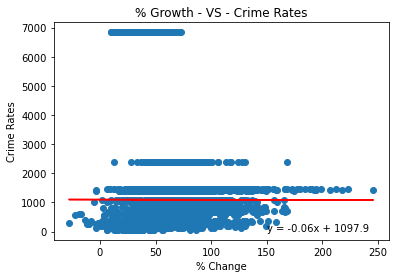

In [10]:
x_values = ideal_place_final['% Change']
y_values = ideal_place_final['Total Crimes']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values.astype(float), y_values.astype(float))
regression_values = x_values * slope + intercept
line_regression = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regression_values,"r-")
plt.annotate(line_regression,(150,5),fontsize=10,color="black")
plt.title('% Growth - VS - Crime Rates')
plt.xlabel('% Change')
plt.ylabel('Crime Rates')
plt.savefig("Resources_Laura/Property Growth vs Crime Rates.png")

print(f"The r-squared is : {round(st.pearsonr(x_values, y_values)[0],2)}")
print(line_regression)

plt.show()

# Input from user to find their ideal place to buy

In [11]:
interest = input('Are you buying to live in the property, or rent it out? (live/rent)')

Are you buying to live in the property, or rent it out? (live/rent)rent


In [12]:
budget = input('What is your budget? (type digits only)')

What is your budget? (type digits only)600000


In [13]:
bedrooms = input('How many bedrooms would you want? (1, 2, or 3)')

How many bedrooms would you want? (1, 2, or 3)2


In [14]:
print('The following attributes may contribute to quality of life. Pick your poison.')

The following attributes may contribute to quality of life. Pick your poison.


In [15]:
walk_score = input('From a score of 0 to 100, what is the minimum walk score that you would like? (type digits)')

From a score of 0 to 100, what is the minimum walk score that you would like? (type digits)30


In [16]:
bike_score = input('From a score of 0 to 60, what is the minimum bike score that you would like? (type digits)')

From a score of 0 to 60, what is the minimum bike score that you would like? (type digits)30


In [17]:
crime_score = input('How comfortable are you with crime rates? (very comfortable/comfortable/somewhat comfortable/not comfortable)')

How comfortable are you with crime rates? (very comfortable/comfortable/somewhat comfortable/not comfortable)comfortable


In [18]:
#conditions to filter through the data

ideal_place_bdr = ideal_place_final.loc[ideal_place_final['Bdrm']==int(bedrooms)]
ideal_place_budget = ideal_place_bdr.loc[ideal_place_bdr['3/31/21']<=int(budget)]
ideal_walk_score = ideal_place_budget.loc[ideal_place_budget['walk score']>=int(walk_score)]
ideal_bike_score = ideal_walk_score.loc[ideal_walk_score['bike score']>=int(bike_score)]

# setting quartiles for the crime rates sensitivity
crime_dataset = ideal_bike_score['Total Crimes']
comfortable = crime_dataset.quantile(.25)
somewhat_comfortable = crime_dataset.quantile(.5)
not_comfortable = crime_dataset.quantile(.75)



#crime rate room for sensitivity
if crime_score == 'comfortable':
    ideal_crime_score = ideal_bike_score.loc[ideal_bike_score['Total Crimes']>=comfortable]
    if crime_score == 'somewhat comfortable':
        ideal_crime_score = ideal_bike_score.loc[ideal_bike_score['Total Crimes']>=somewhat_comfortable]
        if crime_score == 'not comfortable':
            ideal_crime_score = ideal_bike_score.loc[ideal_bike_score['Total Crimes']>=not_comfortable]
else:
    ideal_crime_score = ideal_bike_score

In [19]:
my_place = ideal_crime_score

In [20]:
if interest == "rent":
    my_place = my_place.sort_values(['Median_ROI','% Change'], ascending = False)
else:
    my_place = my_place.sort_values(by = '% Change', ascending = False)

In [21]:
print(f'''
Based on your preferences in investment to {interest}, bedrooms({bedrooms}), budget (${budget}), min. walk score({walk_score}), min. bike score ({bike_score}), crime comfortability ({crime_score}), your ideal top 10 zip-codes to live, with the highest % growth or ROI, are:''')
my_place = my_place.head(10)
my_place


Based on your preferences in investment to rent, bedrooms(2), budget ($600000), min. walk score(30), min. bike score (30), crime comfortability (comfortable), your ideal top 10 zip-codes to live, with the highest % growth or ROI, are:


,ZipCode,RegionType,StateName,State,City,Metro,County,1/31/14,2/28/21,3/31/21,Bdrm,% Change,Lat,Lng,walk score,bike score,Median_ROI,Total Crimes
871,92637,Zip,CA,CA,Laguna Woods,Los Angeles-Long Beach-Anaheim,Orange County,284062.0,332187,330228,2,16.252086,33.610868,-117.728541,51,36.0,7.48,1046.571429
941,92701,Zip,CA,CA,Santa Ana,Los Angeles-Long Beach-Anaheim,Orange County,287452.0,446511,448957,2,56.185033,33.746392,-117.860447,95,59.0,7.21,1046.571429
771,93534,Zip,CA,CA,Lancaster,Los Angeles-Long Beach-Anaheim,Los Angeles County,118505.0,247789,251470,2,112.202017,34.694628,-118.147377,76,67.0,6.13,1444.427184
1444,92557,Zip,CA,CA,Moreno Valley,Riverside-San Bernardino-Ontario,Riverside County,181012.0,331387,336851,2,86.093187,33.969691,-117.255854,39,31.0,6.11,1069.971429
3577,95670,Zip,CA,CA,Rancho Cordova,Sacramento--Roseville--Arden-Arcade,Sacramento County,180291.0,326232,329304,2,82.651380,38.596112,-121.296967,67,68.0,5.55,1424.470588
661,91605,Zip,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,340993.0,566404,571659,2,67.645377,34.208195,-118.398784,50,62.0,5.43,1444.427184
1119,91730,Zip,CA,CA,Rancho Cucamonga,Riverside-San Bernardino-Ontario,San Bernardino County,242916.0,384153,388969,2,60.124899,34.096531,-117.584802,53,52.0,5.32,834.000000
1754,92122,Zip,CA,CA,San Diego,San Diego-Carlsbad,San Diego County,386407.0,567864,569595,2,47.408044,32.856385,-117.202936,61,55.0,5.27,1402.148148
1215,92336,Zip,CA,CA,Fontana,Riverside-San Bernardino-Ontario,San Bernardino County,215129.0,380314,384064,2,78.527302,34.145515,-117.467384,49,42.0,5.26,834.000000
1235,92346,Zip,CA,CA,Highland,Riverside-San Bernardino-Ontario,San Bernardino County,125347.0,266222,269565,2,115.055007,34.128636,-117.208937,55,39.0,5.11,834.000000


In [22]:
my_place_roi = my_place['Median_ROI'].to_list()

if interest == 'rent':
    if my_place['Median_ROI'].isnull().values.any():
        print('Sorry! we do not have rental ROI information for some of these cities')
    else:
        print('Be a smart investor!')

Be a smart investor!


In [23]:
# plotting the maps

zipcodes = my_place["ZipCode"].tolist()
marker_locations = my_place[['Lat', 'Lng']]

# Create a marker_layer using the zipcode list to fill the info box and combine both maps together
fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations,
    info_box_content=[f"Profitable: {zipcodes}" for zipcode in zipcodes])
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))